C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, segment, 2)
C:\Users\Qasim\AppData\Local\Temp\ipykernel_18736\193583193.py:54: RankWarning: Polyfit may be

EODB bin edges: [1.00000000e-03 1.30115117e-03 1.69299435e-03 2.20284158e-03
 2.86622988e-03 3.72939835e-03 4.85251101e-03 6.31385036e-03
 8.21527375e-03 1.06893130e-02 1.39084121e-02 1.80969466e-02
 2.35468631e-02 3.06380284e-02 3.98647063e-02 5.18700091e-02
 6.74907227e-02 8.78156325e-02 1.14261413e-01 1.48671370e-01
 1.93443926e-01 2.51699790e-01 3.27499475e-01 4.26126324e-01
 5.54454762e-01 7.21429460e-01 9.38688783e-01 1.22137600e+00
 1.58919481e+00 2.06778268e+00 2.69049784e+00 3.50074440e+00
 4.55499765e+00 5.92674050e+00 7.71158531e+00 1.00339382e+01
 1.30556704e+01 1.69874007e+01 2.21031763e+01 2.87595736e+01
 3.74205526e+01 4.86897957e+01 6.33527844e+01 8.24315492e+01
 1.07255906e+02 1.39556147e+02 1.81583644e+02 2.36267770e+02
 3.07420084e+02 4.00000000e+02]
Number of EODB bins: 50


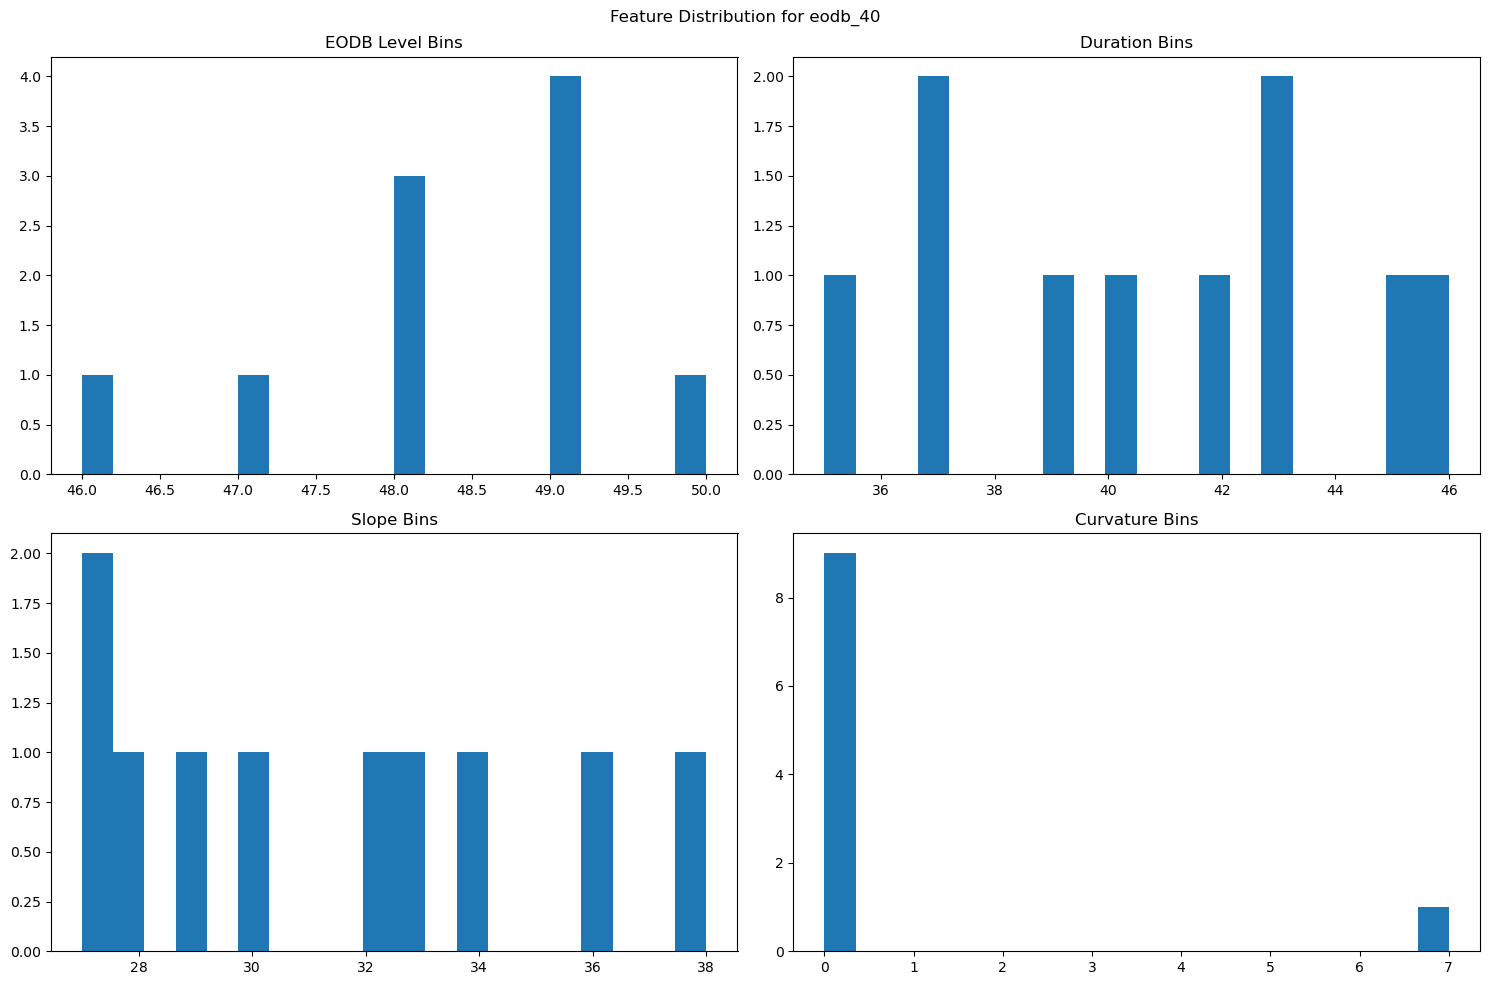

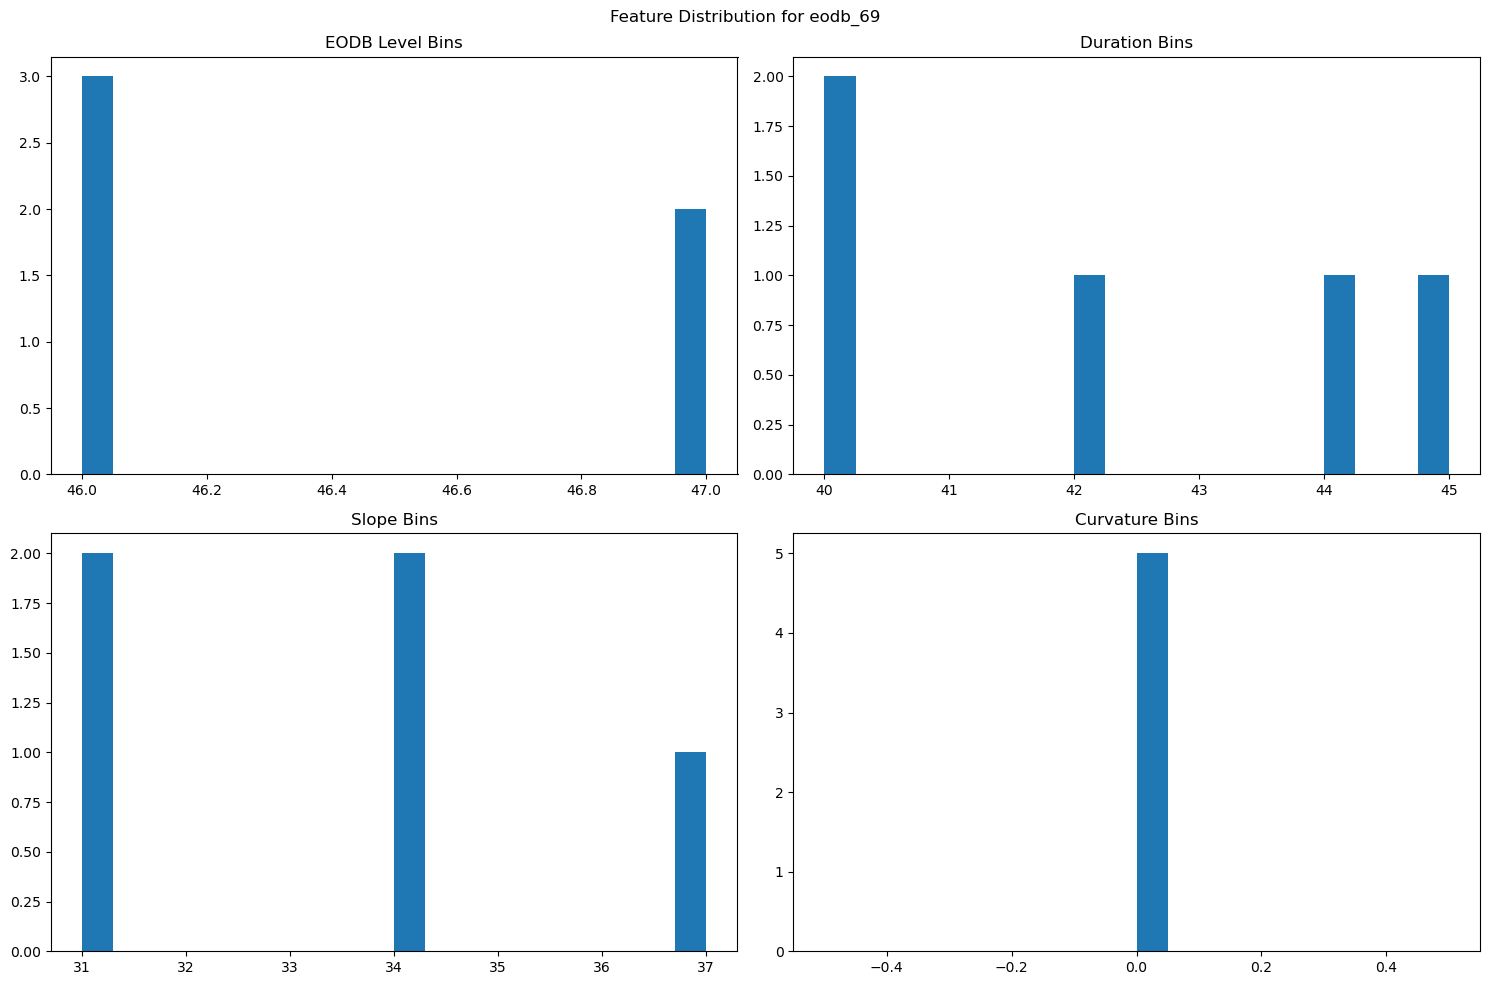

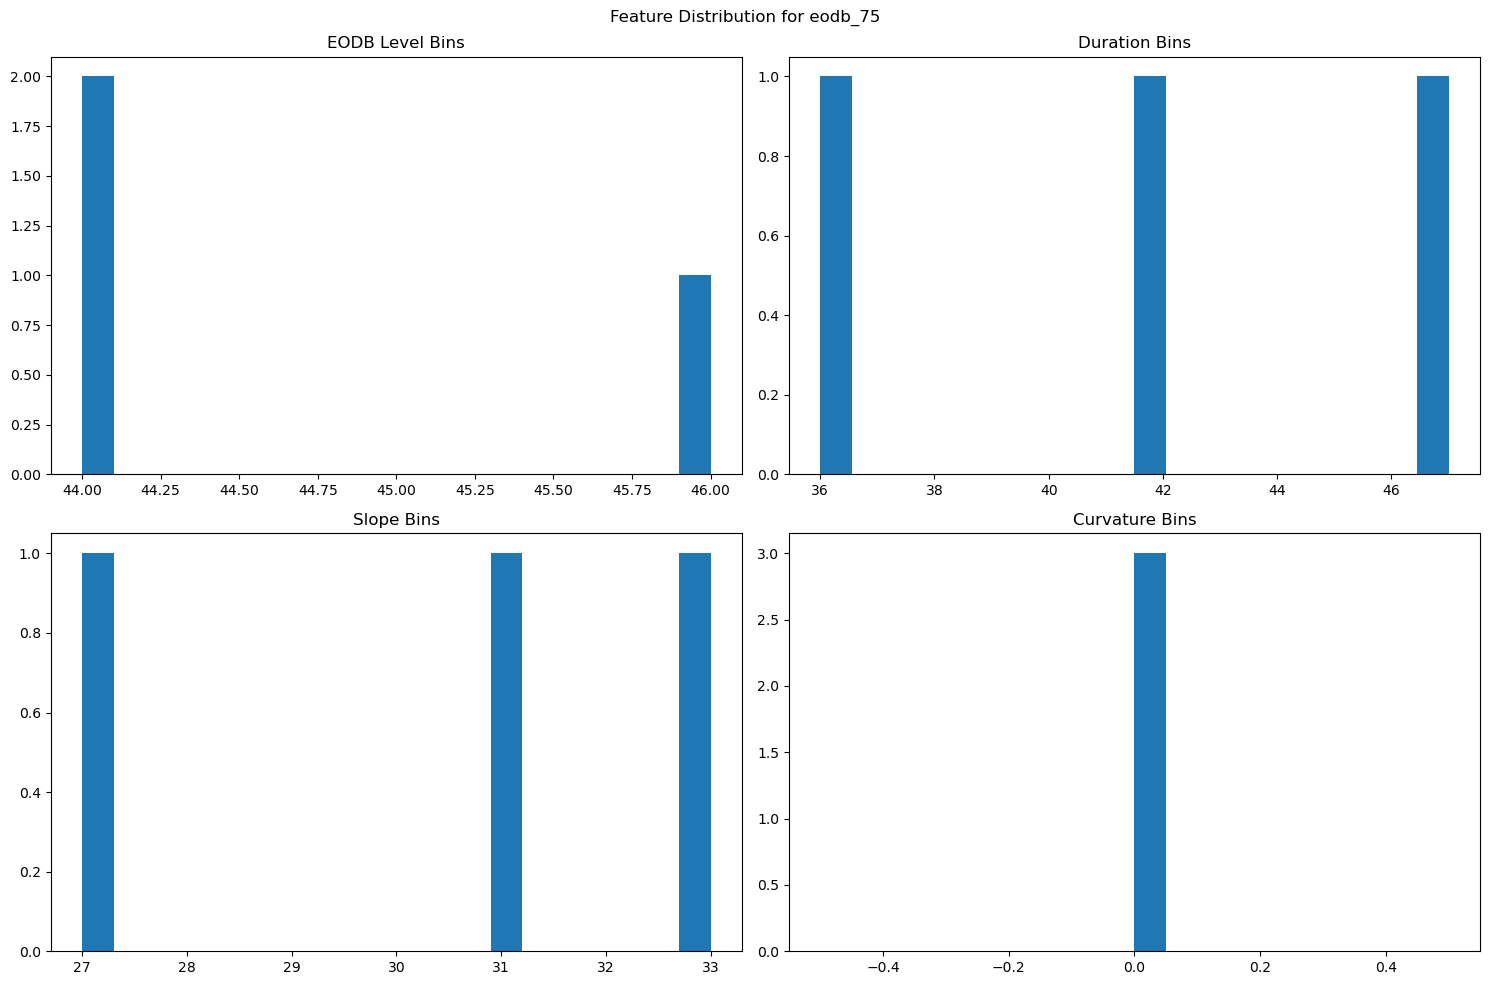

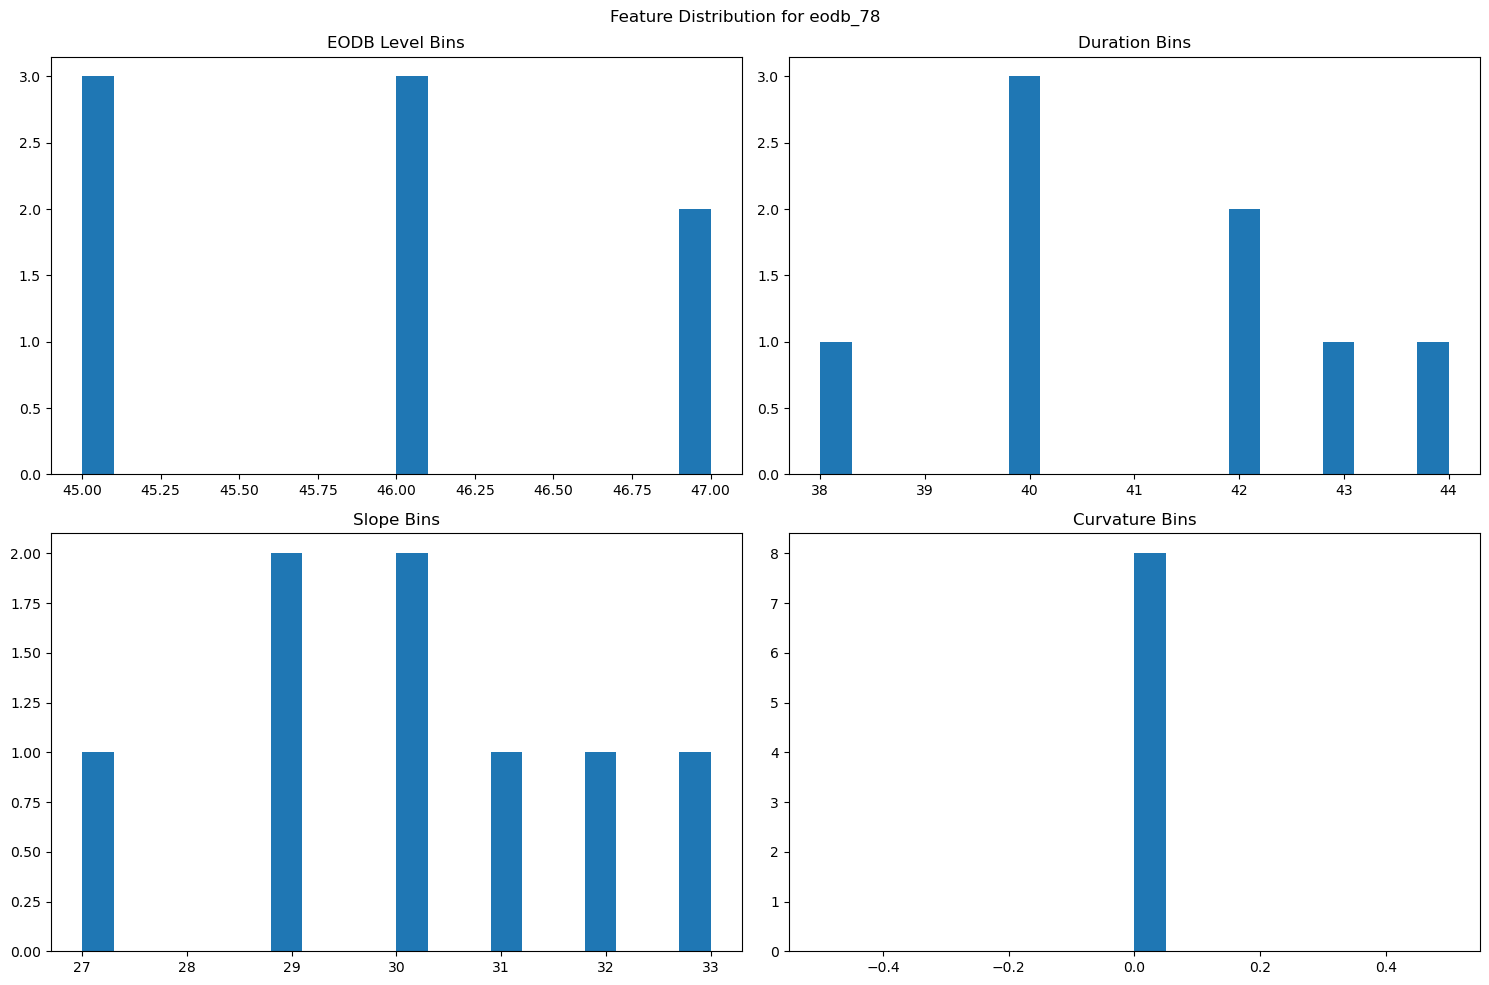

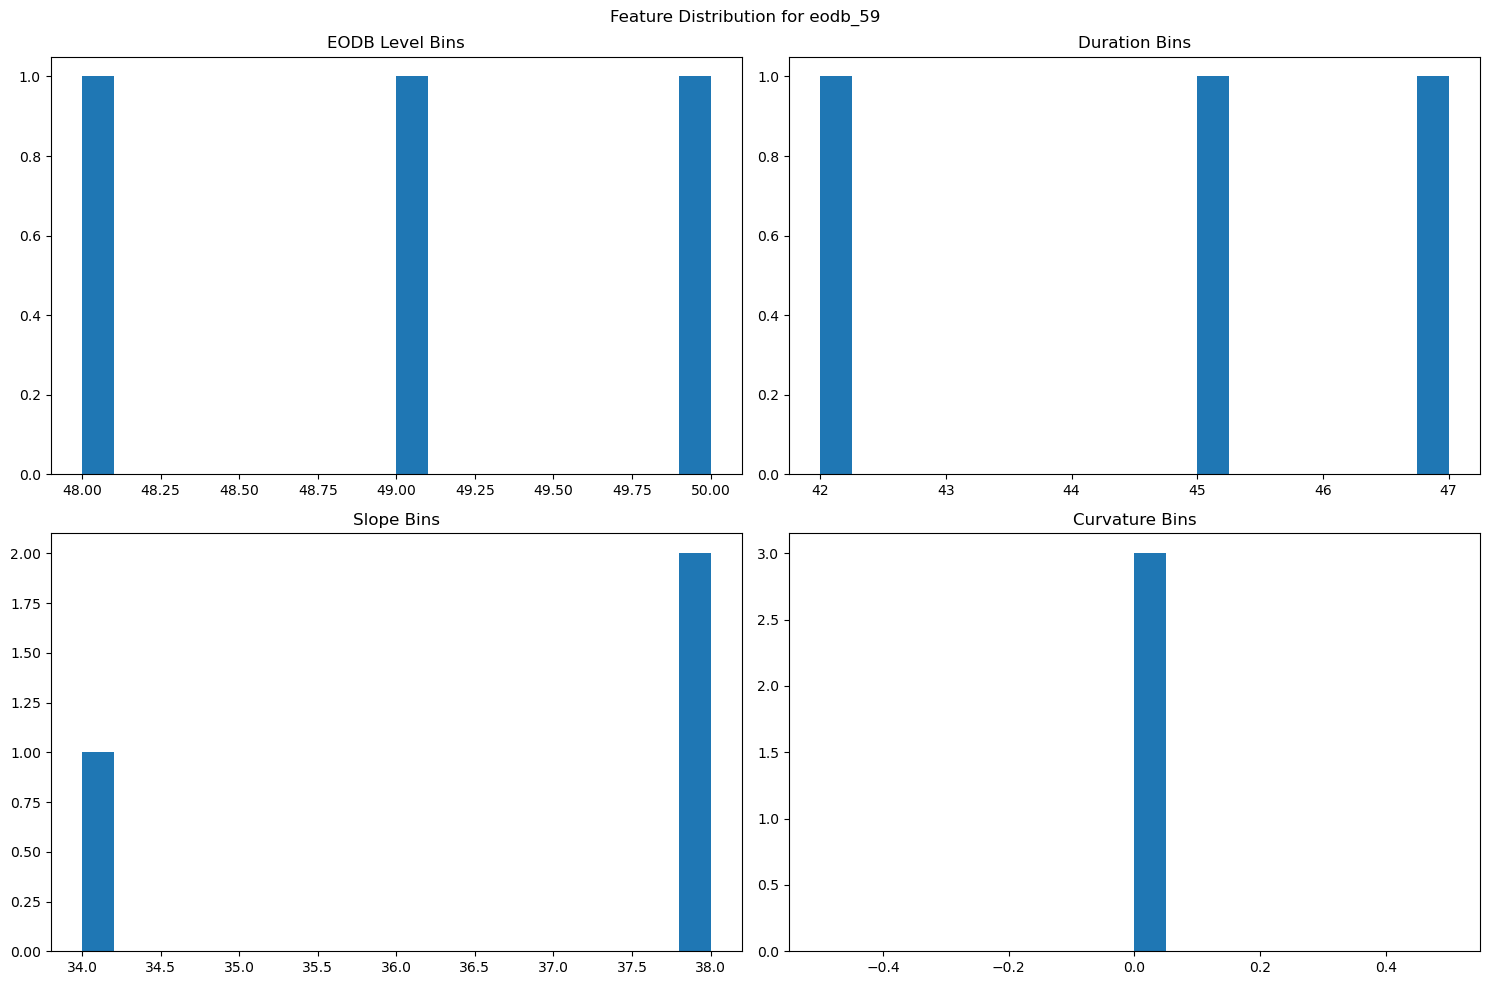

Processed 100 series
Results saved to data\features\binned_features.pkl


In [1]:
# Import cell
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List
import random

# Configuration cell
INPUT_CONFIG = {
    'input_path': Path('data/segments'),
    'input_filename': 'macd_segments.pkl',
    'output_path': Path('data/features'),
    'output_filename': 'binned_features.pkl',
    'display_count': 5
}

# Feature Binning Classes cell
@dataclass

class BinningConfig:
    def __init__(self):
        self.n_bins = 50
        self.eodb_bins = np.geomspace(0.001, 400, self.n_bins)  # Start near 0, extend to 400
        self.duration_bins = np.geomspace(0.001, 100, self.n_bins)
        self.slope_bins = np.geomspace(0.001, 100, self.n_bins)
        self.curvature_bins = np.geomspace(0.001, 100, self.n_bins)


class GeometricBinner:
    def __init__(self, config: BinningConfig):
        self.config = config
    
    def bin_eodb_level(self, value: float) -> int:
        return np.digitize(value, self.config.eodb_bins)
    
    def bin_duration(self, days: float) -> int:
        return np.digitize(days, self.config.duration_bins)
    
    def bin_slope(self, slope: float) -> int:
        return np.digitize(slope, self.config.slope_bins)
    
    def bin_curvature(self, curvature: float) -> int:
        return np.digitize(curvature, self.config.curvature_bins)

# Feature Extraction Functions cell
def extract_segment_features(series: np.ndarray, start: int, end: int) -> Dict:
    """Extract features from a segment"""
    segment = series[start:end+1]
    x = np.arange(len(segment))
    
    # Fit polynomial for trend and curvature
    coeffs = np.polyfit(x, segment, 2)
    
    return {
        'eodb_level': np.mean(segment),
        'duration': end - start,
        'slope': coeffs[1],  # Linear coefficient
        'curvature': coeffs[0]  # Quadratic coefficient
    }

def process_series_segments(segments_dict: Dict, binner: GeometricBinner) -> Dict:
    """Process all segments in a series"""
    binned_features = {}
    
    for series_id, data in segments_dict.items():
        series_features = []
        
        for start, end in zip(data['starts'], data['ends']):
            # Extract raw features
            features = extract_segment_features(data['series'], start, end)
            
            # Bin features
            binned = {
                'eodb_bin': binner.bin_eodb_level(features['eodb_level']),
                'duration_bin': binner.bin_duration(features['duration']),
                'slope_bin': binner.bin_slope(features['slope']),
                'curvature_bin': binner.bin_curvature(features['curvature']),
                'raw_features': features,  # Keep raw features for visualization
                'segment_range': (start, end)
            }
            series_features.append(binned)
            
        binned_features[series_id] = series_features
    
    return binned_features

# Execution cell
# Load MACD segments
input_file = INPUT_CONFIG['input_path'] / INPUT_CONFIG['input_filename']
segments_dict = pd.read_pickle(input_file)

# Initialize binner
binner = GeometricBinner(BinningConfig())

# Process all segments
binned_features = process_series_segments(segments_dict, binner)
config = BinningConfig()
print("EODB bin edges:", config.eodb_bins)
print("Number of EODB bins:", len(config.eodb_bins))
# Save results
INPUT_CONFIG['output_path'].mkdir(exist_ok=True, parents=True)
output_file = INPUT_CONFIG['output_path'] / INPUT_CONFIG['output_filename']
pd.to_pickle(binned_features, output_file)

# Visualization cell
sample_series = random.sample(list(binned_features.keys()), INPUT_CONFIG['display_count'])

for series_id in sample_series:
    features = binned_features[series_id]
    segments = segments_dict[series_id]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Feature Distribution for {series_id}')
    
    # Plot histograms of binned features
    eodb_bins = [f['eodb_bin'] for f in features]
    duration_bins = [f['duration_bin'] for f in features]
    slope_bins = [f['slope_bin'] for f in features]
    curvature_bins = [f['curvature_bin'] for f in features]
    
    axes[0,0].hist(eodb_bins, bins=20)
    axes[0,0].set_title('EODB Level Bins')
    
    axes[0,1].hist(duration_bins, bins=20)
    axes[0,1].set_title('Duration Bins')
    
    axes[1,0].hist(slope_bins, bins=20)
    axes[1,0].set_title('Slope Bins')
    
    axes[1,1].hist(curvature_bins, bins=20)
    axes[1,1].set_title('Curvature Bins')
    
    plt.tight_layout()
    plt.show()

print(f"Processed {len(binned_features)} series")
print(f"Results saved to {output_file}")
